**IMPORT LIBRARY**

In [40]:

! pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

**`IMPORT DATA`**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Case Study - Customer.csv to Case Study - Customer.csv
Saving Case Study - Product.csv to Case Study - Product.csv
Saving Case Study - Store.csv to Case Study - Store.csv
Saving Case Study - Transaction.csv to Case Study - Transaction.csv


In [18]:
#assign data ke variabel masing2 dan cek isinya
df_customer = pd.read_csv('Case Study - Customer.csv', sep= ';')
df_product = pd.read_csv('Case Study - Product.csv', sep= ';')
df_store = pd.read_csv('Case Study - Store.csv', sep= ';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', sep= ';')

df_customer.info()
df_product.info()
df_store.info()
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      ------------

**DATA PREPARATION**

In [19]:
df1 = pd.merge(df_transaction, df_customer, on='CustomerID', how='inner')
df2 = pd.merge(df1, df_store, on = 'StoreID', how = 'inner')
df_merged = pd.merge(df2, df_product, on = 'ProductID', how = 'inner')
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [22]:
#terdapat data yang jumlahnya berbeda sehingga akan disamakan dengan dihapus
df_merged.dropna(inplace = True)
df_merged.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Product Name      0
Price_y           0
dtype: int64

In [26]:
#mengubah tipe data yang kurang sesuai
df_merged['Date'] = pd.to_datetime(df_merged['Date'], dayfirst=True)
df_merged.Date

0      2022-01-01
1      2022-07-17
2      2022-09-26
3      2022-08-01
4      2022-10-01
          ...    
5015   2022-07-14
5016   2022-03-09
5017   2022-08-03
5018   2022-07-07
5019   2022-05-22
Name: Date, Length: 4976, dtype: datetime64[ns]

**PREDICTIVE MODEL USING REGRESSION**

<Axes: xlabel='Date'>

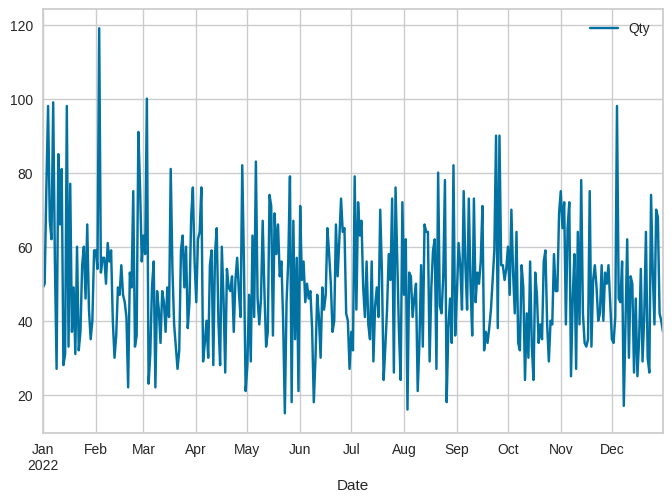

In [28]:
df_reg = df_merged.groupby('Date').agg({'Qty':'sum'})
df_reg.plot()

In [31]:
#membagi data ke Data Train & Data Test
print(df_reg.shape)
test_size = round(df_reg.shape[0] * 0.20)
train=df_reg.iloc[:-1*(test_size)]
test=df_reg.iloc[-1*(test_size):]
print(train.shape,test.shape)

(365, 1)
(292, 1) (73, 1)


In [34]:
#melakukan uji stasioner
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df_reg)

1. ADF :  -19.091513872408132
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


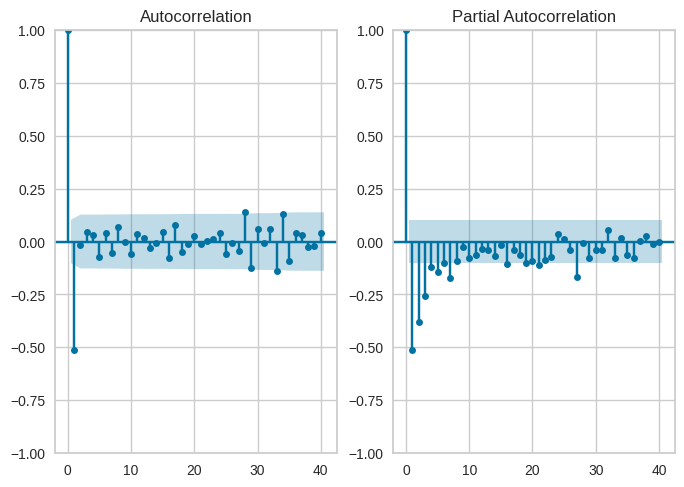

In [36]:
# ACF and PACF plots to determine p and q values
fig, ax = plt.subplots(1, 2)
plot_acf(df_reg.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_reg.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [37]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [38]:
from itertools import product
# Membuat list untuk p, d, dan q
p = range(0, 4)  # 0-3
d = range(0, 4)  # 0-3
q = range(0, 4)  # 0-3
# Menggunakan fungsi product dari itertools untuk membuat kombinasi p, d, dan q
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3)]


In [41]:
from statsmodels.tsa.arima.model import ARIMA
# Membuat list untuk menyimpan Skor AIC
aic_scores = []
# Melakukan grid search manual untuk menemukan p, d, q yang optimal
for param in pdq:
    # Melakukan fitting ARIMA model
    model = ARIMA(df_reg, order=param)
    model_fit = model.fit()
    # Menambahkan aic score ke list
    aic_scores.append({'par': param, 'aic': model_fit.aic})

# Memilih aic score terkecil
best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (0, 1, 1), 'aic': 3092.322287245266}


In [42]:
#Hyperparameter tuning
model_hyper = ARIMA(train, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

In [43]:
#Trial and error tuning
model_manual = ARIMA(train, order=(40,2,2))
model_fit_manual = model_manual.fit()

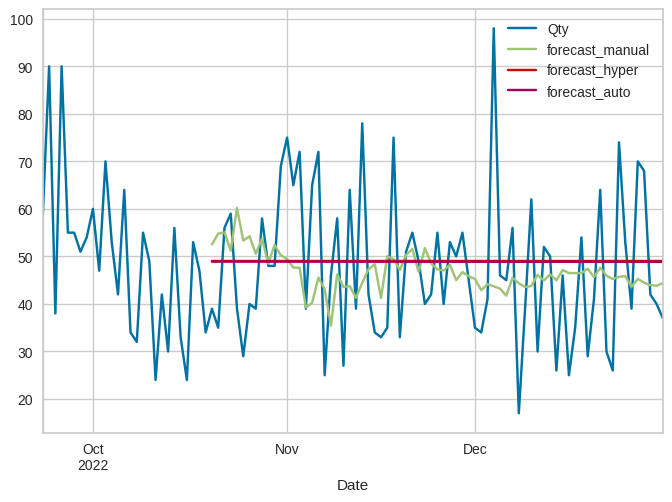

In [44]:
#plot forecasting
forecast_manual = model_fit_manual.forecast(len(test))
forecast_hyper = model_fit_hyper.forecast(len(test))
forecast_auto = auto_arima.predict(len(test))

df_plot = df_reg.iloc[-100:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(forecast_manual)) + list(forecast_manual)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_hyper)) + list(forecast_hyper)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

In [45]:
#Manual parameter tuning metrics

mae = mean_absolute_error(test, forecast_manual)
mape = mean_absolute_percentage_error(test, forecast_manual)
rmse = np.sqrt(mean_squared_error(test, forecast_manual))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 12.6164
mape - manual: 0.2928
rmse - manual: 15.9346


In [46]:
#Hyperparameter tuning metrics

mae = mean_absolute_error(test, forecast_hyper)
mape = mean_absolute_percentage_error(test, forecast_hyper)
rmse = np.sqrt(mean_squared_error(test, forecast_hyper))

print(f'mae - hyper: {round(mae,4)}')
print(f'mape - hyper: {round(mape,4)}')
print(f'rmse - hyper: {round(rmse,4)}')

mae - hyper: 12.7851
mape - hyper: 0.3121
rmse - hyper: 15.5394


In [47]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(test, forecast_auto)
mape = mean_absolute_percentage_error(test, forecast_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 12.7764
mape - auto: 0.3116
rmse - auto: 15.5332


In [49]:
#Apply model to forecast data
model = ARIMA(df_reg, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [51]:
forecast

2023-01-01    55.523695
2023-01-02    45.365967
2023-01-03    46.601693
2023-01-04    51.821927
2023-01-05    43.810817
2023-01-06    34.053792
2023-01-07    44.320102
2023-01-08    36.799709
2023-01-09    42.903144
2023-01-10    52.491967
2023-01-11    39.333549
2023-01-12    39.515091
2023-01-13    43.628411
2023-01-14    37.874994
2023-01-15    42.259335
2023-01-16    45.053409
2023-01-17    44.717009
2023-01-18    52.022296
2023-01-19    40.613386
2023-01-20    41.114261
2023-01-21    50.601378
2023-01-22    37.095120
2023-01-23    40.021486
2023-01-24    55.768285
2023-01-25    48.061416
2023-01-26    41.702018
2023-01-27    50.588222
2023-01-28    41.949732
2023-01-29    41.081617
2023-01-30    46.314133
2023-01-31    46.176714
Freq: D, Name: predicted_mean, dtype: float64

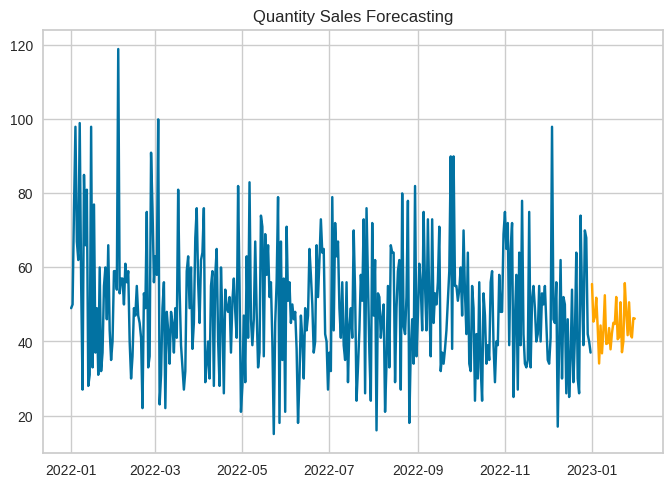

In [52]:
#Plot forecasting
plt.figure()
plt.plot(df_reg)
plt.plot(forecast,color='orange')
plt.title('Quantity Sales Forecasting')
plt.show()

In [53]:
forecast.describe()

count    31.000000
mean     44.489828
std       5.541731
min      34.053792
25%      40.847501
50%      43.810817
75%      47.331555
max      55.768285
Name: predicted_mean, dtype: float64

Dapat disimpulkan bahwa berdasarkan hasil forecast, stok persediaan harian yang perlu dipersiapkan adalah sekitar 44 buah per hari (mengambil nilai rata2)

**CLUSTERING**

In [54]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500


In [58]:
df_cluster = df_merged.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


In [59]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     444 non-null    int64
 1   TransactionID  444 non-null    int64
 2   Qty            444 non-null    int64
 3   TotalAmount    444 non-null    int64
dtypes: int64(4)
memory usage: 14.0 KB


In [60]:
#Standarisasi dataset
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)
df_std.isna().sum()

CustomerID       0
TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [61]:
#Normalisasi dataset dengan minmaxscaler
X_norm = MinMaxScaler().fit_transform(X)
X_norm

array([[0.        , 0.77777778, 0.72463768, 0.70394911],
       [0.00224215, 0.55555556, 0.68115942, 0.39782666],
       [0.0044843 , 0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.9955157 , 0.83333333, 0.84057971, 0.6561092 ],
       [0.99775785, 0.44444444, 0.46376812, 0.43890803],
       [1.        , 0.55555556, 0.46376812, 0.46011132]])

In [62]:
# Normalisasi dataset dengan preprocessing sklearn
X_norm2 = preprocessing.normalize(df_cluster)
X_norm2

array([[1.60436386e-06, 2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [5.09813912e-06, 3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [6.72344235e-06, 3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [7.57833564e-04, 3.06539419e-05, 1.15803781e-04, 9.99999706e-01],
       [1.05362568e-03, 2.59862836e-05, 9.92203555e-05, 9.99999440e-01],
       [1.01752735e-03, 2.95925181e-05, 9.56065970e-05, 9.99999477e-01]])

In [63]:
X_std

array([[-1.73423982,  1.78828224,  1.50893374,  2.10242393],
       [-1.72644745,  0.55344971,  1.27289149,  0.24634281],
       [-1.71865509,  1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 1.72556993,  2.09699037,  2.13837973,  1.81236104],
       [ 1.7333623 , -0.06396655,  0.09268025,  0.49542729],
       [ 1.74115466,  0.55344971,  0.09268025,  0.62398702]])

In [64]:
df_std

,CustomerID,TransactionID,Qty,TotalAmount
0,-1.734240,1.788282,1.508934,2.102424
1,-1.726447,0.553450,1.272891,0.246343
2,-1.718655,1.170866,1.194211,0.679428
3,-1.710863,-0.372675,0.407403,-0.475199
4,-1.703070,-1.298799,-1.087531,-0.747585
...,...,...,...,...
439,1.702193,0.553450,-0.300723,-0.741157
440,1.717778,2.096990,1.666295,1.736029
441,1.725570,2.096990,2.138380,1.812361
442,1.733362,-0.063967,0.092680,0.495427


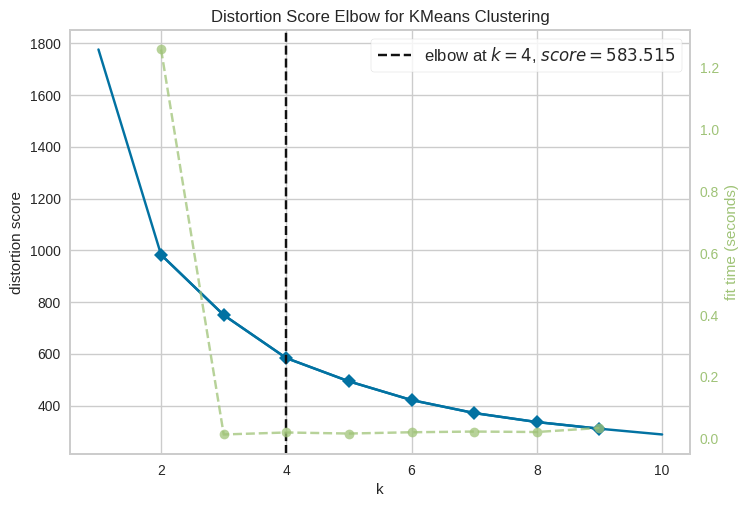

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)

plt.figure()
plt.plot(list(range(1,11)), wcss)

#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [72]:
# Kmeans n_cluster = 4
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [73]:
# Memasukkan cluster ke dataset
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount,cluster
0,1,17,60,623300,2
1,2,13,57,392300,0
2,3,15,56,446200,2
3,4,10,46,302500,0
4,5,7,27,268600,0


<Figure size 600x600 with 0 Axes>

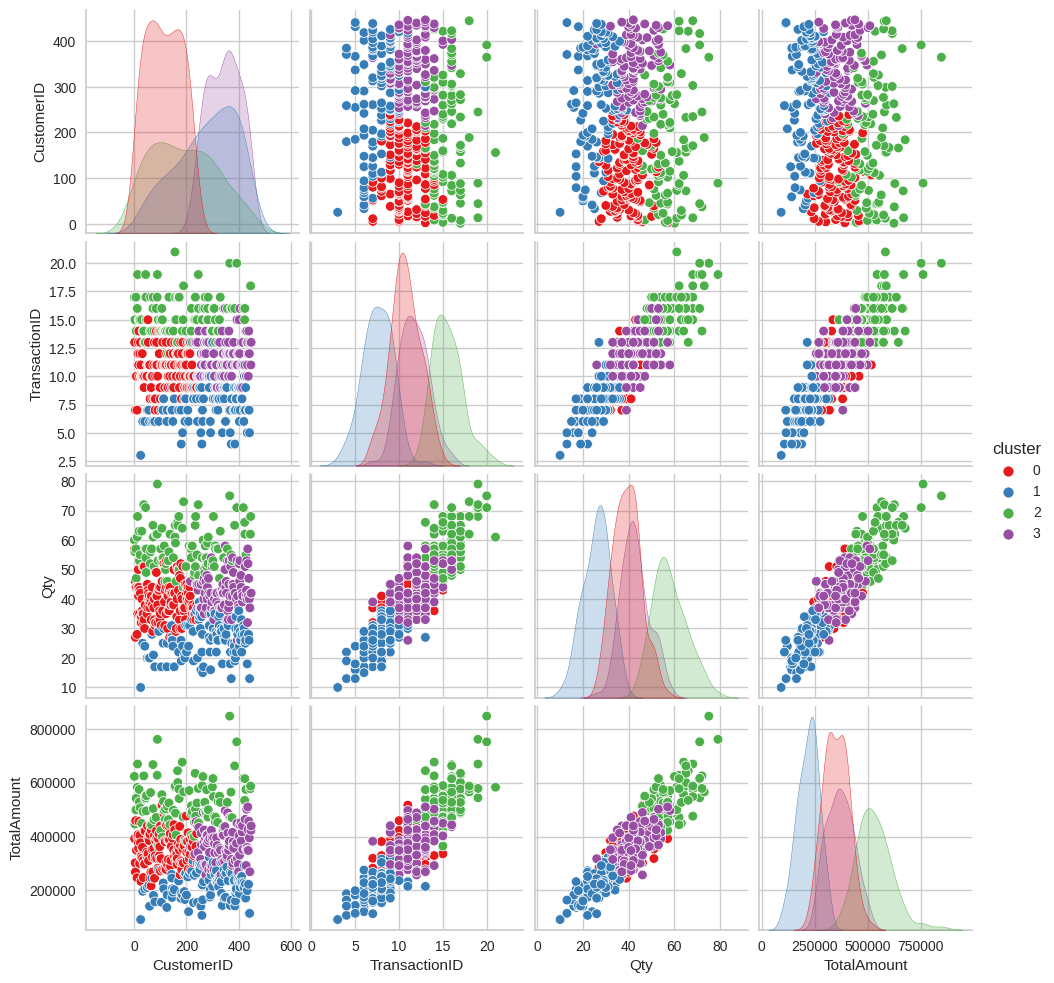

In [74]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set1')
plt.show()

In [78]:
df_cluster['CustomerID'] = df_preclust['CustomerID']
df_cluster_mean = df_cluster.groupby('cluster').agg({'CustomerID':'count','TransactionID':'mean','Qty':'mean','TotalAmount':'mean'})
df_cluster_mean.sort_values('CustomerID', ascending = False)

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
0,134,10.716418,39.238806,349954.477612
1,112,7.571429,26.008929,219599.107143
3,100,11.700000,42.750000,370404.000000
2,98,15.530612,57.948980,531013.265306


Dari hasil clustering tersebut, diketahui bahwa:



*   Cluster 0 memiliki paling banyak pelanggan, namun secara jumlah transaksi, quantity, dan total amount hasilnya kedua terendah dari antara cluster lainnya. Hal ini bisa jadi menunjukkan cluster pelanggan yang memperhatikan value deal ketika membeli barang, sehingga dapat dicoba untuk pemberian promo dan bundling produk untuk meningkatkan transaksi, quality dan total amount.
*   Cluster 1 memiliki cukup banyak pelanggan, dengan transaksi, quantity, dan total amount yang lebih sedikit. Hal ini perlu diteliti lebih lanjut tentang bagaimana karakteristik dari pelanggan2 tersebut supaya bisa lebih banyak memberikan keuntungan pada perusahaan.
*   Cluster 2 memiliki paling sedikit pelanggan, namun dengan transaksi, quantity, dan total amount yang paling banyak. Kemungkinan besar cluster 2 terdiri dari pelanggan2 loyal dan perlu dipertahankan dengan baik
*   Cluster 3 memiliki cukup sedikit pelanggan, namun transaksi, quantity, dan total amount yang mencapai kedua tertinggi. Kemungkinan pelanggan sudah memiliki ketertarikan untuk menjadi loyal, namun belum dapat menegaskannya. Perlu dipastikan mereka mendapatkan produk dan layanan terbaik untuk meningkatkan kepercayaan mereka.




